/var/folders/j_/spz3d5c94g10vgp3snz3jh8c0000gn/T/ipykernel_51153/1975365655.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pp.groupby(["gender", "age_group"], as_index=False)


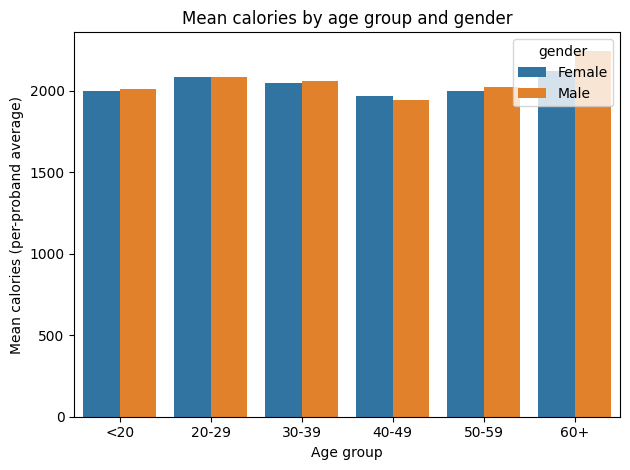

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# normalizing
def snake(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    return re.sub(r"_+", "_", s).strip("_")

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [snake(c) for c in df.columns]
    return df

# loading csvs
nutrition = load_csv("nutrition_probid.csv")
proband   = load_csv("proband_probid.csv")
workout   = load_csv("workout_probid.csv")

# preparing the data/variables
nut_per = (
    nutrition.groupby("proband_id", as_index=False)
    .agg(
        avg_calories=("calories", "mean"),
        avg_water=("water_intake_liters", "mean"),
        avg_meals=("daily_meals_frequency", "mean"),
    )
)

# calculating intensity for query 2
workout = workout.assign(
    intensity=workout["calories_burned"] / workout["session_duration_hours"].replace(0, np.nan)
)

int_per = (
    workout.groupby("proband_id", as_index=False)
    .agg(avg_intensity=("intensity", "mean"))
)

per_proband = (
    proband[["proband_id", "gender", "age"]]
    .merge(nut_per, on="proband_id", how="inner")
    .merge(int_per, on="proband_id", how="inner")
)

# query 1: mean calories by gender & age_group
bins   = [0, 19, 29, 39, 49, 59, np.inf]
labels = ["<20", "20-29", "30-39", "40-49", "50-59", "60+"]

pp = per_proband.copy()
pp["age_group"] = pd.cut(pp["age"], bins=bins, labels=labels, right=True)

grouped = (
    pp.groupby(["gender", "age_group"], as_index=False)
    .agg(
        n_probands=("proband_id", "count"),
        mean_calories=("avg_calories", "mean"),
        sd_calories=("avg_calories", "std"),
    )
)

grouped[["mean_calories", "sd_calories"]] = grouped[["mean_calories", "sd_calories"]].round(2)

# Plot query 1
sns.barplot(data=grouped, x="age_group", y="mean_calories", hue="gender")
plt.title("Mean calories by age group and gender")
plt.ylabel("Mean calories (per-proband average)")
plt.xlabel("Age group")
plt.tight_layout()
plt.show()
